## Wilson - Cowan whole brain simulation

To model the coarse grained activity of large neuronal populations so called neural mass models or mean field have been used since the 1970s. They are typically cast as systems of ordinary differential equations (ODEs) for neural activity evolution. The one of the most used  is the Wilson-Cowan and related equations [Wilson, H., and Cowan, J. (1972)](https://doi.org/10.1016/S0006-3495(72)86068-5) They were able to model many elements of observed neural phenomena [(Chow & Karimipanah, 2020)](https://journals.physiology.org/doi/full/10.1152/jn.00404.2019).   The original equations refer to two-dimensional model that aim to describe activity of  two populations of neurons, inhibitory and excitatory populations. There are several modifications of activity equations, here we use the modification described in paper inhibitory and excitatory populations [(Papadopoulos et al., 2020)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008144). The dynamics of the $j$ brain area described with coupled differential equations:

$$\tau_{E} \dot{E_i} = - E_i + (1- E_i)f_{E}(c_{EE}*E_i - c_{IE}*I_i+K_{gl}\sum_j C_{ij}E_{j-delay_{ij}}+PE_i) + OU_{i}$$

$$\tau_{I} \dot{I_i} = - I_i + (1- I_i)f_{I}(c_{EI}*E_i-c_{II}*I_i+PI_i) + OU_{i}$$


$$f_E=\frac{1.0} {(1 + \exp(-a_{exc} * (x - \mu_{exc}))}$$
$$f_I=\frac{1.0} {(1 + \exp(-a_{inh} * (x - \mu_{inh}))}$$


The variables $E$ and $I$ corresponds to firing rates of excitatory and inhibitory populations of region j, and $\tau_E$ and $\tau_I$ are the excitatory and inhibitory time constants, respectively. $f_E$ and $f_I$ are the non-linear response (activation) functions  with the $a_{exc}$ and $a_{inh}$ - excitatory and inhibitory gain, and $\mu_{exc}$ excitatory and $\mu_{inh}$ inhibitory firing threshold.


Dynamics of the both populations in region $i$ are driven by the next sources:
 - local interaction between excitatory and inhibitory populations inside the one region, i.e. local E-E($c_{EE}$), E-I ($c_{EI}$), I-E ($c_{IE}$), I-I ($c_{II}$) coupling  
  - long-range excitation from other populations ($C_{ij}$)
  - non-specific background drive $PE_i$
  - noise $OU$ (here modelled with Ornstein-Uhlenbeck process)
  
  
Furthermore, $K_{gl}$ is a global coupling that tunes the overall interaction strength between different brain areas, and $delay_{ij}$ is a time delay between regions $i$ and $j$ that arises due to the spatial embedding of the brain network   


Usually, anatomical structural connectivity  matrix used as long-range coupling  matrics $C$...
=== And our wonderfull approach with synaptic weights comes here .....


In [1]:
from tqdm import tqdm
import xarray as xr
import sys
sys.path.append('..')
from scipy import signal, stats, io
from neurolib.models.wc import WCModel
from neurolib.models import bold
from neurolib.utils import functions
from task_fc_simulation.read_utils import read_onsets_from_input, read_generate_task_matrices
from task_fc_simulation.onset_design_model import WCOnsetDesign, HRF
from task_fc_simulation.weight_matrix_utils import normalize, generate_modulars
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.size'] = 10
plt.rcParams['image.cmap'] = 'plasma'
np.set_printoptions(suppress=True)
%load_ext autoreload
%autoreload 2

## Setting up WC model parameters 

We need to set up model parameters. Default values used in neurolib borrowed from [(Papadopoulos et al., 2020)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008144). But optionally all these values could be modified. 

![Here](https://journals.plos.org/ploscompbiol/article/figure/image?size=large&id=10.1371/journal.pcbi.1008144.t001)

***setting up wilson-cowan model parameters***


In [2]:
wc_params = {'exc_ext': 0.75, # baseline external input to E
             'K_gl': 2.85,  # global coupling strength
             'sigma_ou': 5 * 1e-3, # noise intensity
             'inh_ext': 0, # baseline external input to I
             'tau_ou': 5, # ms Timescale of the Ornstein-Uhlenbeck noise process
             'a_exc': 1.5, # excitatory gain
             'a_inh': 1.5, # inhibitory gain
             'c_excexc': 16, #local E-E coupling
             'c_excinh': 15, # local E-I coupling
             'c_inhexc': 12, # local I-E coupling
             'c_inhinh': 3, # local I-I coupling
             'mu_exc': 3,  # excitatory firing threshold
             'mu_inh': 3,  # inhibitory firing threshold
             'tau_exc': 2.5, # excitatory time constant
             'tau_inh': 3.75, # inhibitory time constant
             'signalV': 10 # signal transmission speed between areas
            }

## Synaptic weight generation

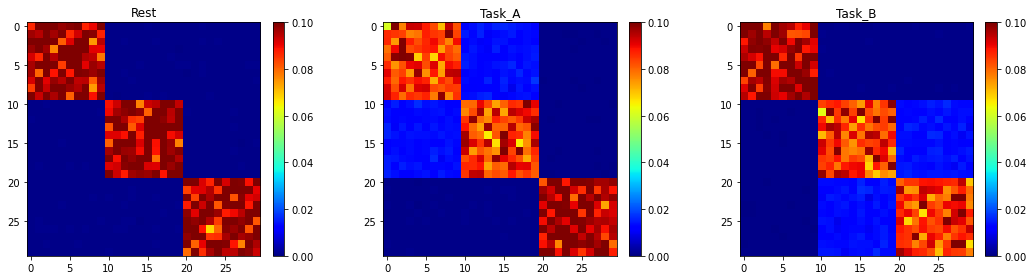

In [3]:
mat_path = '../data/SOTs_1.5s_duration.mat'
N_ROIs = 30
C_rest, C_task_dict = read_generate_task_matrices(mat_path, N_ROIs, num_modules=3,
                                sigma=0.1, norm_type="cols")
C_task_list = list(C_task_dict.values())
C_list = [C_rest]+C_task_list
title_list =['Rest']+ list(C_task_dict.keys())
fig, axs = plt.subplots(1, 3, figsize = (15,4))

#list of possible colormaps here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
for i in [0,1,2]:
    im = axs[i].imshow(C_list[i], cmap='jet', vmin = 0, vmax=0.1); axs[i].set_title(title_list[i]);
    fig.colorbar(im, ax = axs[i], fraction=0.046, pad=0.04);
fig.tight_layout()

## Small input for testing (demonstration) purposes

In [4]:
mat_path = '../data/SOTs_1.5s_duration.mat'
input_data = io.loadmat(mat_path)
small_input_data = input_data.copy()
small_input_data['onsets'][0,0] = input_data['onsets'][0,0][:10]
small_input_data['onsets'][0,1] = input_data['onsets'][0,1][:10]
small_mat_path = "../data/small10SOTs_1.5s_duration.mat"
io.savemat(small_mat_path, small_input_data)

## Simulation setting

Here we need to define simulation regime parameters.
 - :: delay (int or np.array of ints) - delay parameter or delay matrix in number of steps, default = 50
 - :: rest_before (True, False) - if we need to generate rest session before zero time moment 
 - :: first_duration (default 12)  - duration of first rest simulation
 - :: last_duration (default 8) - duration of rest block at the end of session
 - :: TR (default 2) - repetition time for bold resampling (in seconds)
 - :: activity (bool) - if True original neural activity will be saved with a_s_rate 
 - :: a_s_rate (default 0.02) - neuronal activity sampling rate (in seconds)
 

In [5]:
sim_parameters = {"delay": 250,"rest_before":True, "first_duration": 4, "last_duration": 4}
TR = 1
a_s_rate = 5*1e-3 #sampling in s, original integration equal to 0.1 ms or 0.0001s
activity = True
#see notebook HRFConvolution for parameters description
bw_params = {"rho": 0.34, "alpha": 0.32, "V0": 0.02, "k1_mul": None,
                     "k2": None, "k3_mul": None, "gamma": None, "k": None, "tau":None}

In [6]:
%%time
#path to mat file with the predefined structure with onsets and synaptic weights matrices parameters
mat_path = '../data/small10SOTs_1.5s_duration.mat'
wc_block = WCOnsetDesign.from_matlab_structure(mat_path, num_regions= N_ROIs, **wc_params, **sim_parameters)
wc_block.generate_full_series(TR=TR, activity=activity, a_s_rate=a_s_rate, **bw_params)

CPU times: user 9.21 s, sys: 390 ms, total: 9.6 s
Wall time: 9.65 s


## Results
### Neuronal activity

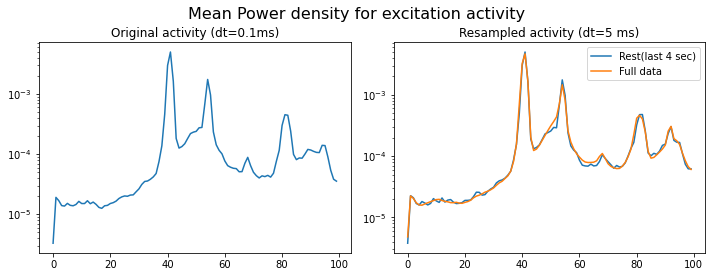

In [7]:
# results verification: power spectrum original acitivity and resampled part for the final resting state 
fig, axs = plt.subplots(1, 2, figsize = (10,4))
maxfr = 100
f, Pxx_Welsh =  functions.getMeanPowerSpectrum(wc_block.wc.exc,0.1, spectrum_windowsize=1, maxfr=maxfr)
axs[0].semilogy(f,  Pxx_Welsh); axs[0].set_title('Original activity (dt=0.1ms)', fontsize=12);
f, Pxx_Welsh =  functions.getMeanPowerSpectrum(wc_block.activity["series"][:,-800:],5, spectrum_windowsize=1, maxfr=maxfr)
axs[1].semilogy(f,  Pxx_Welsh, label="Rest(last 4 sec)"); axs[1].set_title('Resampled activity (dt=5 ms)', fontsize=12);
fig.suptitle("Mean Power density for excitation activity", fontsize=16); 
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
f, Pxx_Welsh =  functions.getMeanPowerSpectrum(wc_block.activity["series"],5, spectrum_windowsize=1, maxfr=maxfr)
axs[1].semilogy(f,  Pxx_Welsh, label="Full data");
axs[1].legend();

## Phase synhronization for neural actvity
Phase synchronization measured as intersite phase clustering. Phase-based connectivity analyses rely on the distribution
of phase angle differences between two electrodes, with the idea that when neural
populations are functionally coupled, the timing of their oscillatory processes, as measured
through phase, becomes synchronized.

$$ISPC_f= \frac{1}{n}\sum_1^n \exp^{i(\phi_x-\phi_y)}$$

Phase angles are obtained by a point in complex space resulting from the convolution between a complex wavelet and the
data or from applying the Hilbert transform to bandpass-filtered data (here we used the hilbert transform).



In [8]:
ds = wc_block.compute_phase_diff(low_f=30, high_f=40, return_xr=True)
print("Results as xarray dataset")
ds

Results as xarray dataset


<xarray.Dataset>
Dimensions:           (region: 30, time: 25834, reg_reg: 435)
Coordinates:
  * time              (time) float64 0.1 5.1 10.1 ... 1.292e+05 1.292e+05
    task_type         (time) <U4 'Rest' 'Rest' 'Rest' ... 'Rest' 'Rest' 'Rest'
    trial_number      (time) int64 -1 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1 -1
    trial_time_point  (time) int64 -1 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1 -1
Dimensions without coordinates: region, reg_reg
Data variables:
    neural_activity   (region, time) float64 0.03827 0.2106 ... 0.1025 0.01202
    phase_diff        (reg_reg, time) float64 0.3569 -0.00374 ... 0.02553
Attributes:
    model:    WC

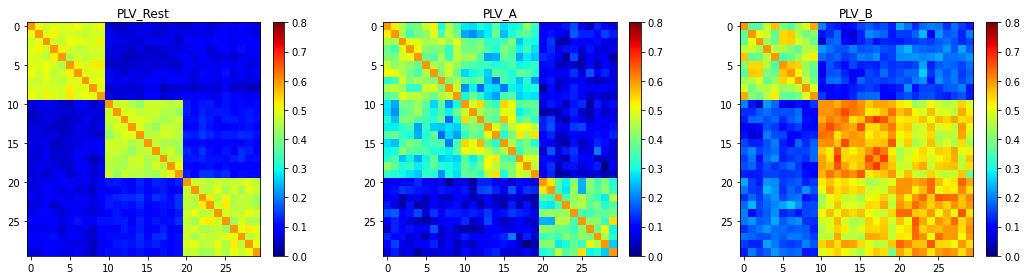

In [9]:
def mean_abs(x, dim=None):
    return abs(np.exp(1j * x).mean(dim=dim))
tasks = ['Rest','A','B']
N_ROIs = ds.dims['region']
title_list = ['PLV_Rest','PLV_A', 'PLV_B']
roi_idx1, roi_idx2 = np.triu_indices(N_ROIs,k=1)
fig, axs = plt.subplots(1, 3, figsize = (15,4))

for i in [0,1,2]:
    synh = ds.groupby('task_type')[tasks[i]].map(mean_abs, dim = 'time').phase_diff.data
    sym_synh = 0.3*np.eye(N_ROIs)
    sym_synh[roi_idx1, roi_idx2] = synh
    im = axs[i].imshow(sym_synh+sym_synh.T, cmap='jet', vmin = 0, vmax=0.8); axs[i].set_title(title_list[i]);
    fig.colorbar(im, ax = axs[i], fraction=0.046, pad=0.04);
fig.tight_layout()


## Envelope 
Raw signal plus envelope and bold signal

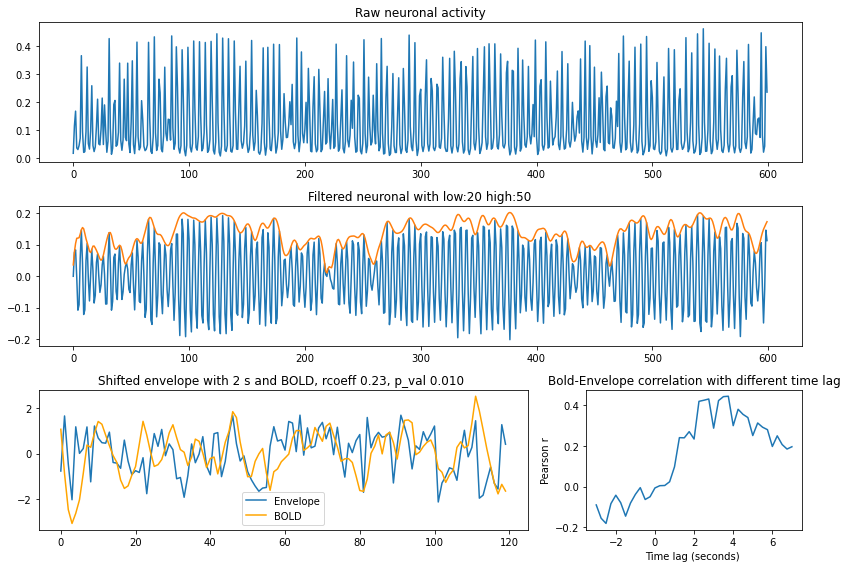

In [10]:
shift_list_sec, rcoeff_list = wc_block.draw_envelope_bold_compare(node_id=2, low_f=20, high_f=50, low_pass=None, 
                               drop_first_sec=9, shift_sec = 2,  plot_first = 3)

## Bold:: external task activation

Hemodynamic Signal = WCO-scaled + SF-loc * TaskDesign⊗HRF

In [11]:
print("Additional activation: ",small_input_data["activations"])

Additional activation:  [[array([[1, 1, 0]], dtype=uint8) array([[0, 1, 1]], dtype=uint8)]]


Here we have next additional local activation:
 - for first block: taskA
 - for second block: taskB+taskA
 - for third block: taskB

so we need to create onset list for all these blocks

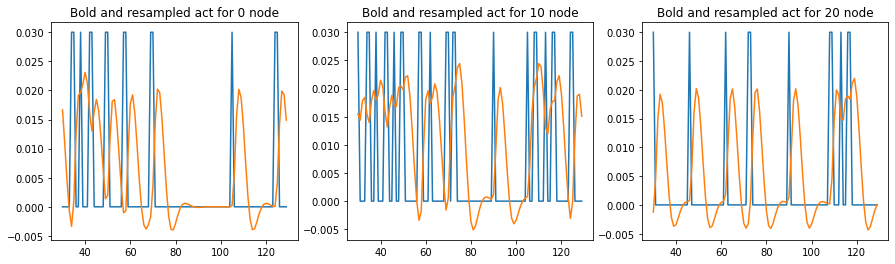

In [12]:
N = wc_block.wc.params["N"]
first_rest = wc_block.first_duration
last_rest = wc_block.last_duration
TR = wc_block.TR
dt = wc_block.wc.params["dt"]
task_duration = float(small_input_data["durations"][0,0].squeeze())

onset_taskA = list(small_input_data['onsets'][0, 0].squeeze().round(2))
onset_taskB = list(small_input_data['onsets'][0, 1].squeeze().round(2))
onset_taskAB,_,_ = read_onsets_from_input(mat_path)
onset_taskAB = list(onset_taskAB)
onsets = [onset_taskA]*(N//3)+[onset_taskAB]*(N//3)+[onset_taskB]*(N//3)


act_scaling = 0.5
hrf = HRF(N, dt=dt, TR=TR, normalize_max=act_scaling)
local_activation = hrf.create_task_design_activation(onsets, duration=task_duration,
                                                          first_rest=first_rest, last_rest=last_rest)
hrf.bw_convolve(local_activation, append=False, **bw_params)
t_res_activ, res_activ = hrf.resample_to_TR(local_activation)

fig, axs = plt.subplots(1, 3, figsize = (15,4))
node_ids = [0,10,20]
draw_last = 100
draw_last_TR = int(draw_last/TR) #in seconds
for i in range(3):
        
    axs[i].plot(t_res_activ[-draw_last_TR:]/1e3, 0.03*res_activ[node_ids[i],-draw_last_TR:]);
    axs[i].plot(t_res_activ[-draw_last_TR:]/1e3, hrf.BOLD[node_ids[i],-draw_last_TR:]); axs[i].set_title(f"Bold and resampled act for {node_ids[i]} node");


### Generate several series

all parameters from the start

In [26]:
%%time
N_subj=2
BOLD_subj = np.zeros((*wc_block.BOLD.T.shape,N_subj ))
for i in tqdm(range(N_subj)):
    wc_block = WCOnsetDesign.from_matlab_structure(mat_path, num_regions= N_ROIs, **wc_params, **sim_parameters)
    wc_block.generate_full_series(TR=TR, activity=False, a_s_rate=a_s_rate, **bw_params)
    BOLD_subj[:,:,i] = wc_block.BOLD.T

100%|█████████████████████████████████████████████| 2/2 [00:15<00:00,  7.90s/it]

CPU times: user 15.2 s, sys: 627 ms, total: 15.8 s
Wall time: 15.9 s


## Saving BOLD and neural actvity to netcdf file

In [27]:
#in task design last point added to simulation
if hrf.t_BOLD.shape[0] > wc_block.t_BOLD.shape[0]:
    hrf.t_BOLD = hrf.t_BOLD[:wc_block.t_BOLD.shape[0]]
    hrf.BOLD = hrf.BOLD[:, :wc_block.t_BOLD.shape[0]]
#check that timing for internal and external bold  coincides    
assert  (hrf.t_BOLD==wc_block.t_BOLD).all()   

In [28]:
bold_vars = {'BOLD_subj': (['timeTR','region', 'Subjs'], BOLD_subj,
             {'long_name': 'Simulated with WC bold resampled with TR',
             'TR': TR}),
             'DesignBold': (['region', 'timeTR'], hrf.BOLD,
              {'long_name': 'External BOLD simulated with BW and task design',
                'TR': TR}),
             'onsets_A': (['indexA'], small_input_data['onsets'][0,0].squeeze(),
                         {'duration': float(small_input_data['durations'][0,0])}),
             'onsets_B': (['indexB'], small_input_data['onsets'][0,0].squeeze(),
                         {'duration': float(small_input_data['durations'][0,1])})
             
            }
coords = {'timeTR': ('timeTR', wc_block.t_BOLD/1000, {'units': 's', 
                          'sampling_rate': TR})
         }
da_BOLD = xr.Dataset(data_vars=bold_vars, coords=coords)
full_ds = xr.merge([da_BOLD,ds]).drop('phase_diff')
full_ds.to_netcdf("../results/"+mat_path.split('/')[-1].split('.mat')[0]+'.nc')

In [29]:
full_ds

<xarray.Dataset>
Dimensions:           (timeTR: 129, region: 30, Subjs: 2, indexA: 10, indexB: 10, time: 25834)
Coordinates:
  * timeTR            (timeTR) float64 0.0001 1.0 2.0 3.0 ... 126.0 127.0 128.0
  * time              (time) float64 0.1 5.1 10.1 ... 1.292e+05 1.292e+05
    task_type         (time) <U4 'Rest' 'Rest' 'Rest' ... 'Rest' 'Rest' 'Rest'
    trial_number      (time) int64 -1 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1 -1
    trial_time_point  (time) int64 -1 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1 -1
Dimensions without coordinates: region, Subjs, indexA, indexB
Data variables:
    BOLD_subj         (timeTR, region, Subjs) float64 1.99e-14 ... 0.06218
    DesignBold        (region, timeTR) float64 0.0 0.0 ... -0.002342 -0.0009327
    onsets_A          (indexA) float64 8.109 20.98 29.59 ... 64.67 100.5 119.7
    onsets_B          (indexB) float64 8.109 20.98 29.59 ... 64.67 100.5 119.7
    neural_activity   (region, time) float64 0.03827 0.2106 ... 0.1025 0.01202